<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/PSO/notebooks/solutions/PSO_cv10_en_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 10 - Segmentation

In this lab we will attempt to separate objects or different parts of images (ground, sky, wall etc.) using per-pixel labels.

## K-means clustering

To cluster the images we will try to use k-means clustering. The algorithm separates $N$ datapoints into $k$ clusters.

The clustering algorithm works by iteratively moving k centers in two steps:

* Every data point is assigned to the center closest to it.
* The centers are moved to a position defined as the center of all of the data points assigned to it in the previous step.

These two steps repeat until the centers do not change between iterations. The algorithm is initialized with the k centers determined randomly. It is also possible that in step 1 there will be a center which will not be assigned any data points. In that case the new center position will be determined randomly (same as during initialization).

We can also run this multiple times with different intialization and pick one based on some criterium (compactness, repeatability etc.)


Visualization:

![](https://upload.wikimedia.org/wikipedia/commons/5/5e/K_Means_Example_Step_1.svg)
![](https://upload.wikimedia.org/wikipedia/commons/a/a5/K_Means_Example_Step_2.svg)
![](https://upload.wikimedia.org/wikipedia/commons/3/3e/K_Means_Example_Step_3.svg)
![](https://upload.wikimedia.org/wikipedia/commons/d/d2/K_Means_Example_Step_4.svg)

Images by Weston.pace licensed by [GNU Free Documentation License](https://en.wikipedia.org/wiki/GNU_Free_Documentation_License)


Each cluster then represents a different part of the image. To perform clustering the distance between points is calculated using color information. Other information can be added as well such as the position of the pixels as pixels that are close to eachother are probably from the same object.



In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()

### Exercise 1 - k-means clustering segmentation

Implement the function `segment_k_means`. On input it will accept an image, the parameter $k$ and as a keyword argument `conversion` it will accept enum for the `cv2.cvtColor` conversion function. When the argument `position_w` greater than zero it will also add the positions of pixels to the color vector for each pixel multiplied by the value `position_w`.

 The function will output an array with the same height and width as the image containing the output with individual pixels assigned labels from $0$ to $k - 1$.

 To test the code you can use the code block below which will also display the segmentation masks.

For k-means you can use `cv2.kmeans` as shown in [the documentation](https://docs.opencv.org/4.x/d1/d5c/tutorial_py_kmeans_opencv.html). For adding the positional information you can use `np.mgrid`.


In [3]:
def segment_k_means(img, k, conversion=None, position_w=0):
    h, w, _ = img.shape

    if conversion is not None:
        img = cv2.cvtColor(img, conversion).astype(np.float32)
    else:
        img = img.astype(np.float32)


    pixels = img.reshape((h * w, -1))


    if position_w > 0:
        x, y = np.meshgrid(range(w), range(h))
        x = x.reshape(h * w)
        y = y.reshape(h * w)
        positions = np.column_stack([x, y]).astype(np.float32)
        pixels = np.column_stack((pixels, position_w * positions))

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 3, cv2.KMEANS_RANDOM_CENTERS)

    # Reshape the labels to match the original image shape
    segmentation = labels.reshape((h, w))

    return segmentation

In [4]:
!wget https://raw.githubusercontent.com/kocurvik/edu/master/PSO/images/building.jpg
!wget https://raw.githubusercontent.com/kocurvik/edu/master/PSO/images/elk.png
!wget https://raw.githubusercontent.com/kocurvik/edu/master/HUPV/supplementary/bear.jpg
!wget https://raw.githubusercontent.com/kocurvik/edu/master/HUPV/supplementary/car.jpg
!wget https://raw.githubusercontent.com/kocurvik/edu/master/HUPV/supplementary/magpie.jpg

--2023-11-20 19:35:57--  https://raw.githubusercontent.com/kocurvik/edu/master/PSO/images/building.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57259 (56K) [image/jpeg]
Saving to: ‘building.jpg.1’

building.jpg.1      100%[===================>]  55.92K  --.-KB/s    in 0.01s   

2023-11-20 19:35:57 (3.99 MB/s) - ‘building.jpg.1’ saved [57259/57259]

--2023-11-20 19:35:57--  https://raw.githubusercontent.com/kocurvik/edu/master/PSO/images/elk.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2017326 (1.9M) [image/png]
Savin

In [5]:
def label_overlay(img, labels):
  k = np.max(labels) + 1
  cmap = plt.get_cmap('tab10')  # You can choose a different colormap if needed

  # Create an overlay based on the labels
  overlay = np.zeros_like(img)

  for label in range(k):
      color = np.array(cmap(label)[:3]) * 255  # Map label to RGB values
      overlay[labels == label] = color

  # Combine the image and overlay
  # output = cv2.addWeighted(img, 1.0, overlay, 0.5, 0)
  # return output

  return overlay

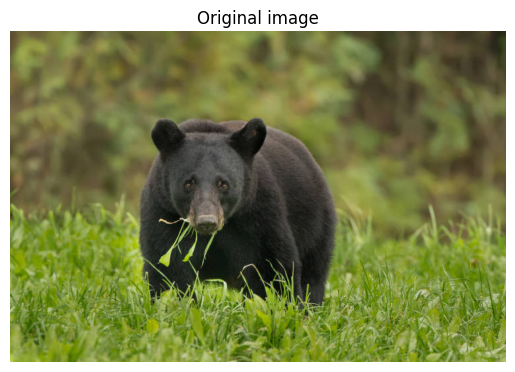

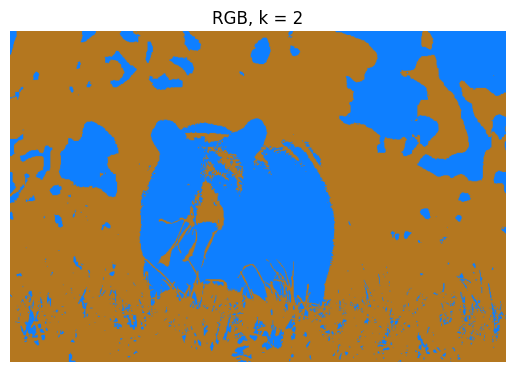

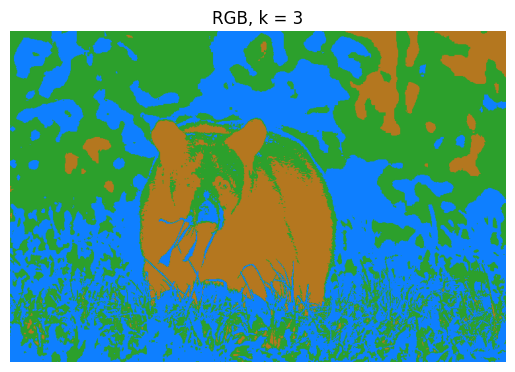

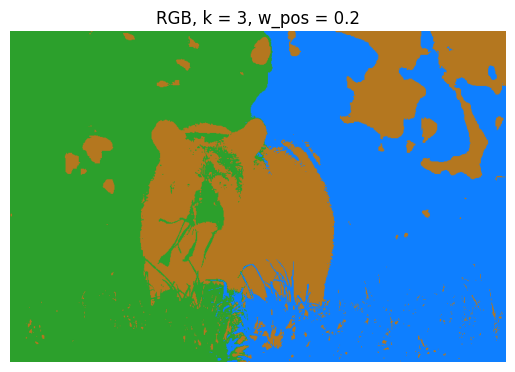

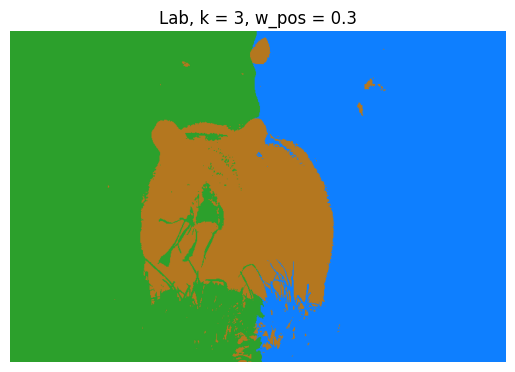

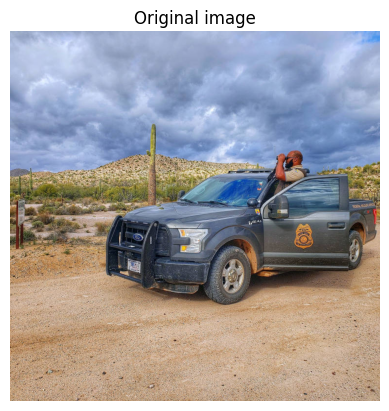

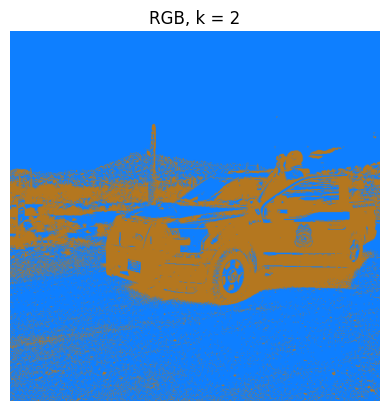

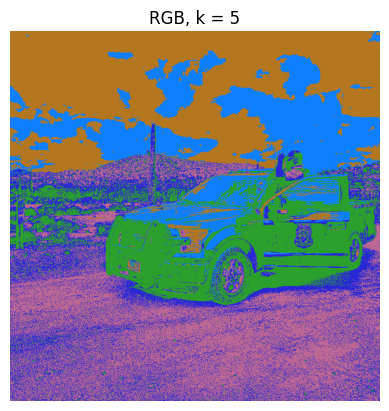

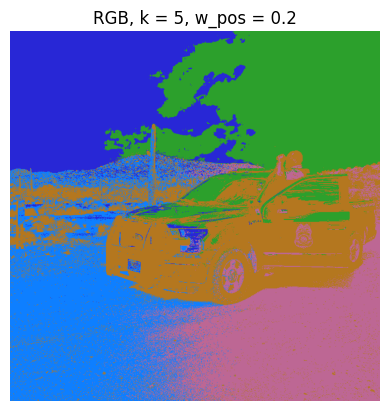

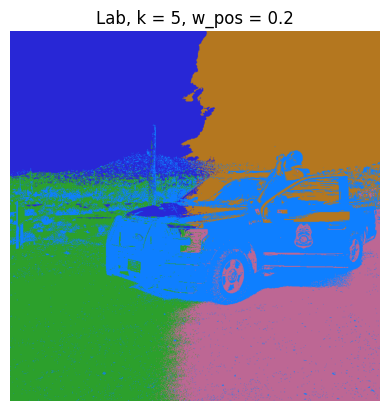

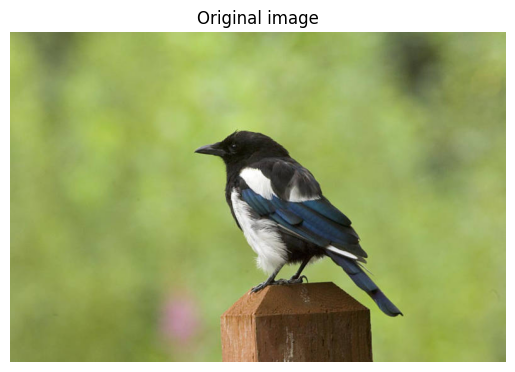

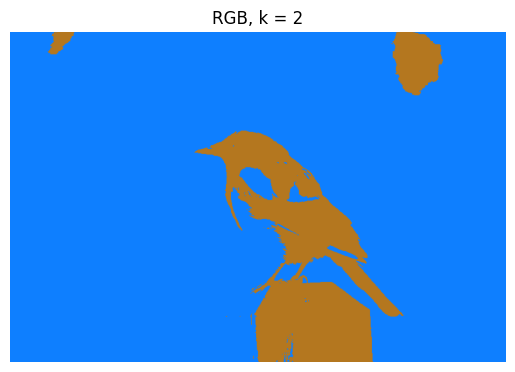

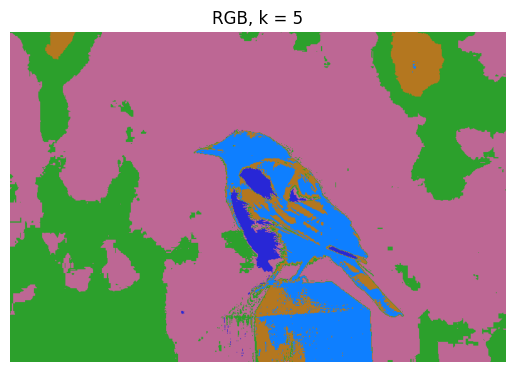

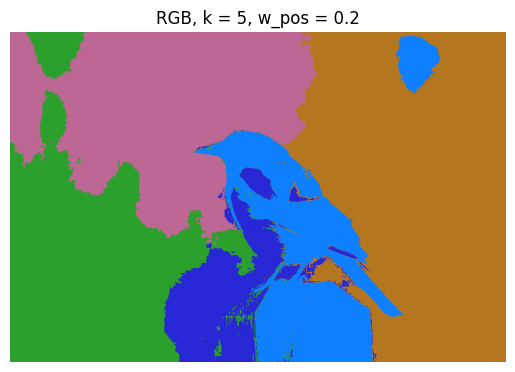

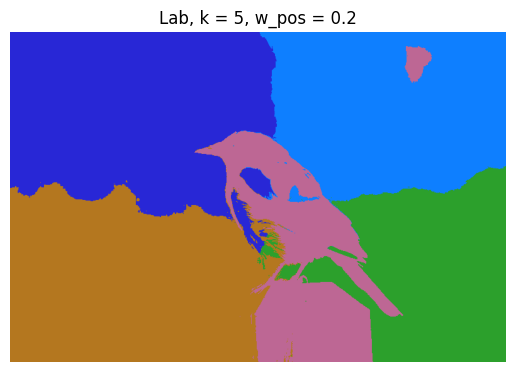

In [6]:
img = cv2.imread('bear.jpg')

plt.imshow(img[:, :, ::-1])
plt.title("Original image")
plt.axis("off")
plt.show()

plt.imshow(label_overlay(img, segment_k_means(img, 2))[:, :, ::-1])
plt.title("RGB, k = 2")
plt.axis("off")
plt.show()

plt.imshow(label_overlay(img, segment_k_means(img, 3))[:, :, ::-1])
plt.title("RGB, k = 3")
plt.axis("off")
plt.show()

plt.imshow(label_overlay(img, segment_k_means(img, 3, position_w=0.2))[:, :, ::-1])
plt.title("RGB, k = 3, w_pos = 0.2")
plt.axis("off")
plt.show()

plt.imshow(label_overlay(img, segment_k_means(img, 3, cv2.COLOR_BGR2Lab, position_w=0.3))[:, :, ::-1])
plt.title("Lab, k = 3, w_pos = 0.3")
plt.axis("off")
plt.show()




img = cv2.imread('car.jpg')

plt.imshow(img[:, :, ::-1])
plt.title("Original image")
plt.axis("off")
plt.show()

plt.imshow(label_overlay(img, segment_k_means(img, 2))[:, :, ::-1])
plt.title("RGB, k = 2")
plt.axis("off")
plt.show()

plt.imshow(label_overlay(img, segment_k_means(img, 5))[:, :, ::-1])
plt.title("RGB, k = 5")
plt.axis("off")
plt.show()

plt.imshow(label_overlay(img, segment_k_means(img, 5, position_w=0.2))[:, :, ::-1])
plt.title("RGB, k = 5, w_pos = 0.2")
plt.axis("off")
plt.show()

plt.imshow(label_overlay(img, segment_k_means(img, 5, cv2.COLOR_BGR2Lab, position_w=0.2))[:, :, ::-1])
plt.title("Lab, k = 5, w_pos = 0.2")
plt.axis("off")
plt.show()




img = cv2.imread('magpie.jpg')

plt.imshow(img[:, :, ::-1])
plt.title("Original image")
plt.axis("off")
plt.show()

plt.imshow(label_overlay(img, segment_k_means(img, 2))[:, :, ::-1])
plt.title("RGB, k = 2")
plt.axis("off")
plt.show()

plt.imshow(label_overlay(img, segment_k_means(img, 5))[:, :, ::-1])
plt.title("RGB, k = 5")
plt.axis("off")
plt.show()

plt.imshow(label_overlay(img, segment_k_means(img, 5, position_w=0.2))[:, :, ::-1])
plt.title("RGB, k = 5, w_pos = 0.2")
plt.axis("off")
plt.show()

plt.imshow(label_overlay(img, segment_k_means(img, 5, cv2.COLOR_BGR2Lab, position_w=0.2))[:, :, ::-1])
plt.title("Lab, k = 5, w_pos = 0.2")
plt.axis("off")
plt.show()



### Exercise 2 - Selecting the segment

Use k-means clusteringm but let the user select the region by clicking (using ipympl) on the selected segment and display a binary mask for the selected segment.

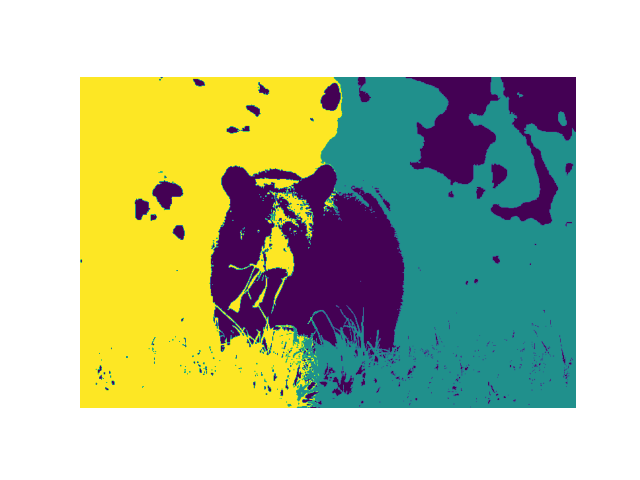

15

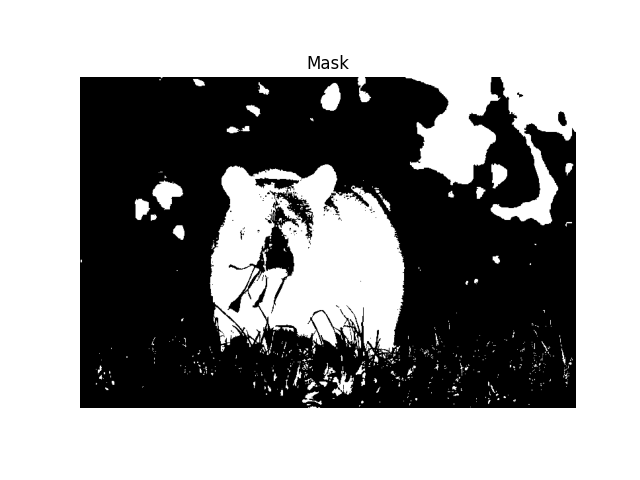

In [10]:
%matplotlib ipympl

img = cv2.imread('bear.jpg')

labels = segment_k_means(img, 3, position_w=0.2)

fig = plt.figure()
plt.axis('off')
plt.imshow(labels)
plt.show()


def onclick(event):
    ix, iy = event.xdata, event.ydata
    label = labels[int(iy), int(ix)]

    mask = np.where(labels == label, 1.0, 0.0)
    plt.figure()
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis("off")
    plt.show()

fig.canvas.mpl_connect('button_press_event', onclick)

### Exercise 3 - Color thresholding

Implement a GUI with a slider to obtain a mask by simply thresholding based on a distance in the Lab colorspace. Let the user select the threshold using a slider and click on a point to calculate the distance from.

AppLayout(children=(FloatSlider(value=10.0, description='Factor:', layout=Layout(grid_area='footer'), max=300.…

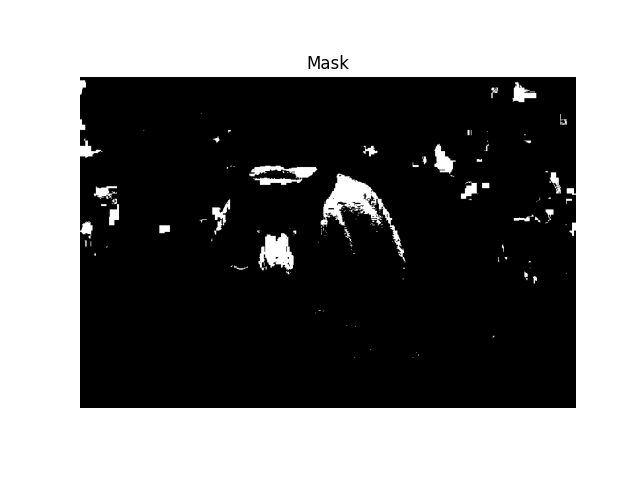

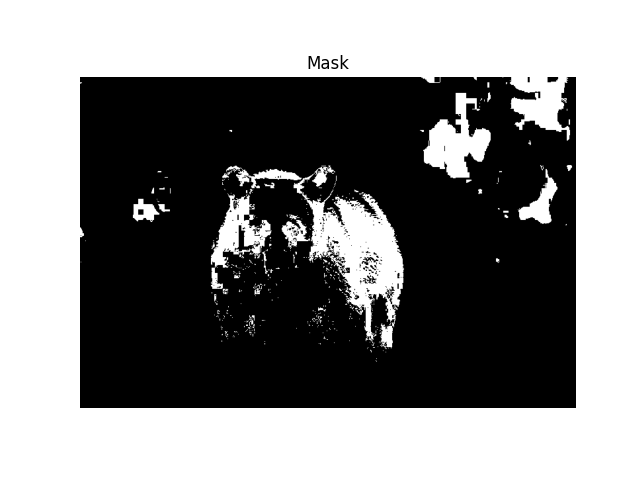

In [13]:
from ipywidgets import AppLayout, FloatSlider

plt.ioff()

slider = FloatSlider(
    orientation='horizontal',
    description='Factor:',
    value=10.0,
    min=0.00,
    max=300.0
)

img = cv2.imread('bear.jpg')

fig = plt.figure()
plt.imshow(img[:, :, ::-1])
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'


def onclick(event):
    ix, iy = event.xdata, event.ydata
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

    selected = lab[int(iy), int(ix)].reshape([1, 1, 3])
    dist = np.linalg.norm(lab - selected, axis=2)


    mask = np.where(dist <  slider.value, 1.0, 0.0)
    plt.figure()
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis("off")
    plt.show()

fig.canvas.mpl_connect('button_press_event', onclick)


layout = AppLayout(center=fig.canvas, footer=slider, pane_heights=[0, 6, 1])
display(layout)